In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler
from preprocessing.sliding_window import create_windowed_dataset

### Data loading

In [3]:
data_path = '/home/hariub/data/HAR/processed/clean_daphnet_data.csv'
df = pd.read_csv(data_path)

In [4]:
df.head()

,Time,Ankle_acc_x,Ankle_acc_y,Ankle_acc_z,Thigh_acc_x,Thigh_acc_y,Thigh_acc_z,Trunk_acc_x,Trunk_acc_y,Trunk_acc_z,Label,Subject,Run
0,15.0,70.0,39.0,-970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,31.0,70.0,39.0,-970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,46.0,60.0,49.0,-960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,62.0,60.0,49.0,-960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,78.0,50.0,39.0,-960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [5]:
FEATURES = ['Ankle_acc_x', 'Ankle_acc_y', 'Ankle_acc_z', 'Thigh_acc_x','Thigh_acc_y', 'Thigh_acc_z', 'Trunk_acc_x', 'Trunk_acc_y','Trunk_acc_z']
LABEL = ['Label']

In [6]:
df = df.fillna(0)
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [7]:
NOVEL_CLASSES = [2]

In [8]:
holdout_data = df.loc[df['Label'].isin(NOVEL_CLASSES)]
novel_data = holdout_data.copy().reset_index(drop=True)

df = df.drop(holdout_data.copy().index)
df = df.reset_index(drop=True)

In [9]:
hyperparameters = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)

metadata = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)['daphnet_preprocess']

In [10]:
train_df = df[(df['Subject'] != 2) & (df['Subject'] != 9)]
test_df = df[df['Subject'] == 2]
val_df = df[df['Subject'] == 9]

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

# FEATURES = metadata['feature_list']

X_train, y_train = create_windowed_dataset(
    train_df, FEATURES, 'Label', window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_val, y_val = create_windowed_dataset(
    val_df, FEATURES, 'Label', window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test = create_windowed_dataset(
    test_df, FEATURES, 'Label', window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_val = X_val.reshape(
    (X_val.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [11]:
X_holdout, y_holdout = create_windowed_dataset(novel_data, FEATURES,LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_holdout = X_holdout.reshape((X_holdout.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
y_holdout = tf.keras.utils.to_categorical(y_holdout)

In [12]:
# from preprocessing.utils import get_train_test_data
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

In [13]:
print(X_train.shape)
print(y_train.shape)

(9296, 10, 32, 9)
(9296, 2)


In [14]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=metadata['n_window'], axis=1)
y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=metadata['n_window'], axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=metadata['n_window'], axis=1)

In [15]:
y_train_mid.shape

(9296, 10, 2)

In [16]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
DATASET_NAME = 'daphnet'
hparams_all = hyperparameters['HSA_model']
hparams = hparams_all[DATASET_NAME]

hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=  y_train.shape[1]

## Training

In [17]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
device_list = ['/gpu:'+str(i) for i in range(6, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hparams).get_compiled_model()

8 Physical GPUs, 8 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 2


In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 32, 9)]  0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 350144      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_3 (Modal (None, None, 64)     104000      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  49856       modality_encoder_block_3[0][0]   
____________________________________________________________________________________________

In [19]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 64, epochs=20, validation_data=(X_val, [y_val_mid, y_val]), use_multiprocessing=True)

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 164 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devi

In [20]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [21]:
# labels_map = {1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'Nordic walking',
#               11:'ascending stairs',12:'descending stairs',13:'vacuum cleaning',
#               14:'ironing', 18:'rope jumping'}
# class_names = list(labels_map.values())

In [22]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       443
           1       0.85      0.84      0.84       490

    accuracy                           0.84       933
   macro avg       0.84      0.84      0.84       933
weighted avg       0.84      0.84      0.84       933



In [23]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       443
           1       0.85      0.84      0.84       490

    accuracy                           0.84       933
   macro avg       0.84      0.84      0.84       933
weighted avg       0.84      0.84      0.84       933



In [24]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       443
           1       0.85      0.84      0.84       490

    accuracy                           0.84       933
   macro avg       0.84      0.84      0.84       933
weighted avg       0.84      0.84      0.84       933



In [25]:
# activity_map

<AxesSubplot:>

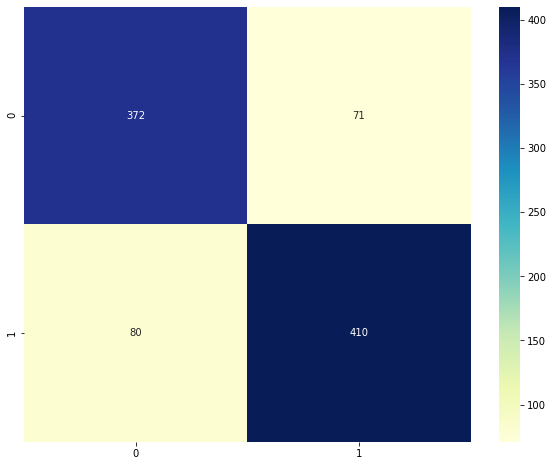

In [26]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [27]:
y_test_mid.shape

(933, 10, 2)

In [28]:
pred_mid.shape

(933, 10, 2)

In [29]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 2), axis=1), np.argmax(pred_mid.reshape(-1, 2), axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      4430
           1       0.85      0.84      0.84      4900

    accuracy                           0.84      9330
   macro avg       0.84      0.84      0.84      9330
weighted avg       0.84      0.84      0.84      9330



<AxesSubplot:>

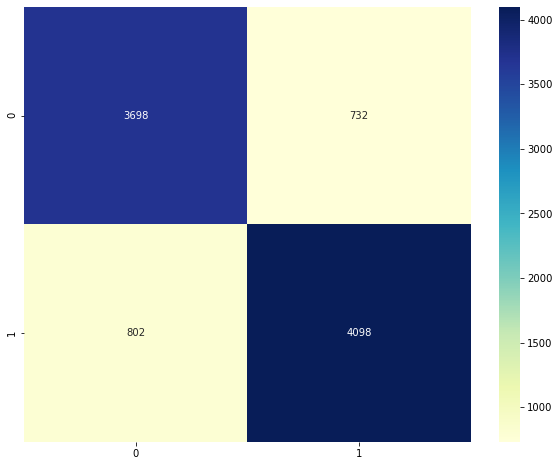

In [30]:
confm = confusion_matrix(np.argmax(y_test_mid.reshape(-1, 2), axis=1), np.argmax(pred_mid.reshape(-1, 2), axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

## VAE

In [31]:
for l in model.layers:
    print(l.name)

input_1
multi_window_encoder
modality_encoder_block_3
combined_sensor_self_attention_1
tf_op_layer_Shape
tf_op_layer_ExpandDims
tf_op_layer_strided_slice_3
tf_op_layer_strided_slice_4
tf_op_layer_Tile
tf_op_layer_concat
tf_op_layer_Reshape
reshape
concatenate
dense_60
dense_61
window_pred
session_pred


In [32]:
hierarchical_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('combined_sensor_self_attention_1').output, name='hierarchical_encoder')
hierarchical_model.trainable = False

In [33]:
hierarchical_model.summary()

Model: "hierarchical_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 32, 9)]       0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 350144    
_________________________________________________________________
modality_encoder_block_3 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 49856     
Total params: 504,000
Trainable params: 0
Non-trainable params: 504,000
_________________________________________________________________


In [34]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim=16, intermediate_dim=32, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, original_dim, intermediate_dim=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        return self.dense_output(x)

class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        base_model,
        original_dim,
        intermediate_dim=32,
        latent_dim=16,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.base_model = base_model
        
        self.original_dim = original_dim
        
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        inputs, _ = self.base_model(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # _data, label = data
            _data = data
            _data, _ = self.base_model(_data)
            z_mean, z_log_var, z = self.encoder(_data)
            reconstructed = self.decoder(z)

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)            
            reconstruction = tf.keras.losses.mean_squared_error(_data, reconstructed)
            # weighted_reconstruction = tf.math.multiply(reconstruction, label)
            # reconstruction_loss = tf.reduce_mean(weighted_reconstruction)
            reconstruction_loss = tf.reduce_mean(reconstruction)
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

### Open set training

In [36]:
with strategy.scope():
    hsa_vae = VariationalAutoEncoder(base_model=hierarchical_model, original_dim=64)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
hsa_vae.compile(optimizer)    

vae_history = hsa_vae.fit(X_train, epochs=60, batch_size=128, verbose=2)

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
73/73 - 10s - loss: 1.1333 - reconstruction_loss: 1.0352 - kl_loss: 0.0981
Epoch 2/60
73/73 - 10s - loss: 0.8929 - reconstruction_loss: 0.8739 - kl_loss: 0.0190
Epoch 3/60
73/73 - 9s - loss: 0.8138 - reconstruction_loss: 0.7789 - kl_loss: 0.0350
Epoch 4/60
73/73 - 10s - loss: 0.7455 - reconstruction_loss: 0.6857 - kl_loss: 0.0598
Epoch 5/60
73/73 - 10s - loss: 0.7069 - reconstruction_loss: 0.6422 - kl_loss: 0.0647
Epoch 6/60
73/73 - 9s - loss: 0.6899 - reconstruction_loss: 0.6249 - kl_loss: 0.0650
Epoch 7/60
73/73 - 10s - loss: 0.6845 - reconstruction_loss: 0.6188 - kl_loss: 0.0657
Epoch 8/60
73/73 - 10s - loss: 0.6816 - reconstruction_loss: 0.6160 - kl_loss: 0.0656
Epoch 9/60
73/73 - 9s - loss: 0.6758 - reconstruction_loss: 0.6094 - kl_loss: 0.0664
Epoch 10/60
73/73 - 10s - loss: 0.6731 - reconstruction_l

## Novelty Result

In [37]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])

In [38]:
def kl_div(z_mean, z_log_var):
    kl_loss = -0.5 * tf.math.reduce_mean((z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1), axis=1)
    return kl_loss.numpy()

In [39]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_train)[0])
train_kl = kl_div(z_mean, z_log_var)

In [40]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_test)[0])
test_kl = kl_div(z_mean, z_log_var)

In [41]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])
holdout_kl = kl_div(z_mean, z_log_var)

In [42]:
def novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.25):
    threshold = np.mean(train_kl) - (mult * np.std(train_kl))
    
    y_holdout = (holdout_kl > threshold).astype(int)
    y_true = np.ones(shape=holdout_kl.shape, dtype=int)
    
    y_test_n = (test_kl > threshold).astype(int)
    _y_true = np.zeros(shape=test_kl.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
#     return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro')
    
    print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [43]:
novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.75)

              precision    recall  f1-score   support

       KNOWN       0.33      0.20      0.25       933
       NOVEL       0.29      0.44      0.35       691

    accuracy                           0.30      1624
   macro avg       0.31      0.32      0.30      1624
weighted avg       0.31      0.30      0.29      1624



In [44]:
train_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_train)[0], hsa_vae.predict(X_train)).numpy()
test_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_test)[0], hsa_vae.predict(X_test)).numpy()
novel_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout)).numpy()

In [45]:
train_rec_loss.shape

(9296,)

In [46]:
novel_rec_loss.shape

(691,)

<AxesSubplot:ylabel='Probability'>

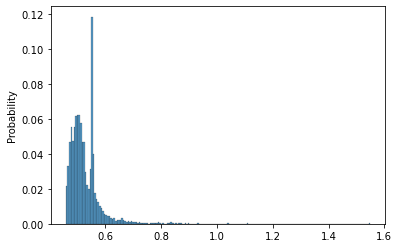

In [47]:
sns.histplot(train_rec_loss, stat="probability")

<AxesSubplot:ylabel='Probability'>

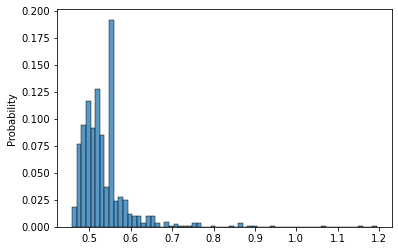

In [48]:
sns.histplot(test_rec_loss, stat="probability")

<AxesSubplot:ylabel='Count'>

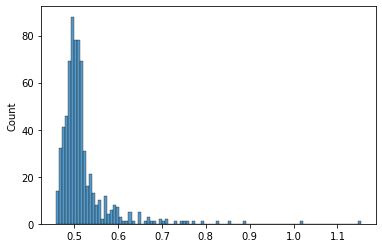

In [49]:
sns.histplot(novel_rec_loss)

<AxesSubplot:xlabel='data', ylabel='Probability'>

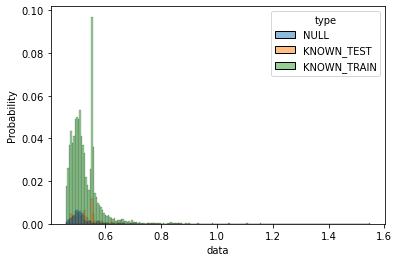

In [50]:
combined = pd.DataFrame({'data': novel_rec_loss, 'type': 'NULL'})
combined = pd.concat([combined, pd.DataFrame({'data': test_rec_loss, 'type': 'KNOWN_TEST'})])
combined = pd.concat([combined, pd.DataFrame({'data': train_rec_loss, 'type': 'KNOWN_TRAIN'})])
sns.histplot(combined, x='data', hue='type', stat="probability")

<AxesSubplot:xlabel='data', ylabel='Probability'>

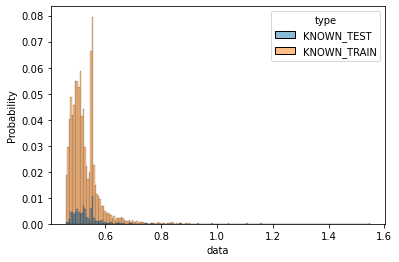

In [51]:
combined = pd.DataFrame()
combined = pd.concat([combined, pd.DataFrame({'data': test_rec_loss, 'type': 'KNOWN_TEST'})])
combined = pd.concat([combined, pd.DataFrame({'data': train_rec_loss, 'type': 'KNOWN_TRAIN'})])
sns.histplot(combined, x='data', hue='type', stat="probability")

In [52]:
def novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=0.25):
    threshold = np.mean(train_rec_loss) - (mult * np.std(train_rec_loss))
    
    y_holdout = (novel_rec_loss > threshold).astype(int)
    y_true = np.ones(shape=novel_rec_loss.shape, dtype=int)
    
    y_test_n = (test_rec_loss > threshold).astype(int)
    _y_true = np.zeros(shape=test_rec_loss.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
    return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro'), 
    
#     print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [53]:
def hparam_search():
    table = list()
    thresh_vals = list(np.arange(0.0, 1.01, 0.01))
    
    idx = 0
    
    for m_val in thresh_vals:
        result = novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=m_val)
        table.append([idx, m_val, result[0], result[1]])
        
        idx = idx + 1
    
    table = np.array(table)
    sns.lineplot(table[:, 1], table[:, 2], label='Accuracy')
    sns.lineplot(table[:, 1], table[:, 3], label='Macro F1')
    plt.xlabel('Hyperparameter Value')
    plt.title('Novelty Detection Experiement')
    plt.show()
    
    top_acc = np.array(pd.Series(table[:, 2]).nlargest().index)
    top_f1 = np.array(pd.Series(table[:, 3]).nlargest().index)
    
    print('Index with Top Accuracy and Macro F1 : ', top_acc, top_f1)
    print('Most Important Index : ', np.intersect1d(top_acc, top_f1))
    
    print(tabulate(table, headers=['Index', 'Std. Multiplier Value', 'Accuracy', 'Macro F1'], tablefmt="grid"))

In [54]:
from tabulate import tabulate

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

/home/hariub/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/hariub/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


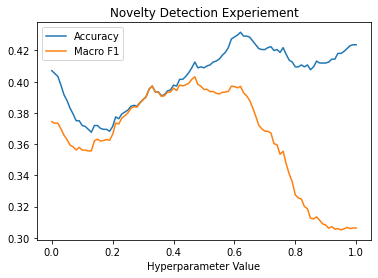

Index with Top Accuracy and Macro F1 :  [62 61 63 64 60] [47 46 45 48 44]
Most Important Index :  []
+---------+-------------------------+------------+------------+
|   Index |   Std. Multiplier Value |   Accuracy |   Macro F1 |
+=========+=========================+============+============+
|       0 |                    0    |   0.40702  |   0.374369 |
+---------+-------------------------+------------+------------+
|       1 |                    0.01 |   0.405172 |   0.373344 |
+---------+-------------------------+------------+------------+
|       2 |                    0.02 |   0.403325 |   0.373383 |
+---------+-------------------------+------------+------------+
|       3 |                    0.03 |   0.397783 |   0.369836 |
+---------+-------------------------+------------+------------+
|       4 |                    0.04 |   0.391626 |   0.365753 |
+---------+-------------------------+------------+------------+
|       5 |                    0.05 |   0.387931 |   0.362884 |
+--

In [57]:
hparam_search() 